# Assignment 8: Spatial data and Magic: The gathering

In [2]:
%load_ext sql
%sql postgresql://appdev@data:5432/appdev

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: appdev@appdev'

## In the first part you'll be processing the data in the geonames table.

### A. Find the tuple with the largest population

In [58]:
%%sql 
DROP VIEW IF EXISTS max_pop;
CREATE VIEW max_pop AS
SELECT * FROM geonames ORDER BY population DESC LIMIT 1;

SELECT * FROM max_pop;

Done.
Done.
1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


### B. Now calculate the distance from all locations to the tuple above using the <-> function

In [10]:
%sql CREATE INDEX location ON geonames USING GIST (longitude, latitude);

Done.


[]

In [38]:
%%sql
SELECT point(longitude, latitude) <-> (SELECT point(longitude, latitude) FROM max_pop) AS distance 
FROM geonames LIMIT 50;

50 rows affected.


distance
35.5187260391022
35.5403912827645
35.4976906065648
35.5211340049413
35.5230848613757
35.5756544866359
35.3803392045427
35.5686877257961
35.4524960679527
35.5086914894509


### Now calculate the distance from all locations to the tuple above using the haversine distance

In [39]:
%%sql
CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
COST 100;

Done.


[]

In [42]:
%%sql SELECT geodistance(latitude, longitude,
                        (SELECT latitude FROM max_pop),
                        (SELECT longitude FROM max_pop)) 
FROM geonames LIMIT 50;

50 rows affected.


geodistance
1948.31948131202
1948.97544410187
1946.67835552112
1948.51401122396
1948.68370586011
1951.17402268074
1940.93606757186
1950.34910315871
1944.25406670841
1947.84095795632


### D. Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot

In [47]:
result =  %sql SELECT longitude, latitude FROM geonames ORDER BY population DESC LIMIT 1000;

1000 rows affected.


In [49]:
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
df = pd.DataFrame(result, columns=['longitude', 'latitude']);

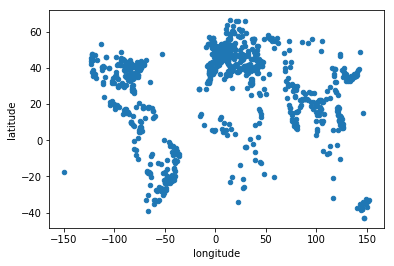

In [63]:
df.plot.scatter(x='longitude', y='latitude');

## 2. In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic: The gathering

### A. Find all the cards that is made by Rob Alexander

In [71]:
%%sql
DROP VIEW IF EXISTS rob_alexander;
CREATE VIEW rob_alexander AS
SELECT data FROM cards WHERE data @> '{"artist":"Rob Alexander"}';

SELECT * FROM rob_alexander LIMIT 10;

Done.
Done.
10 rows affected.


data
"{'id': '4a7bf234af44e07d9a159d4d89e96ce320919917', 'cmc': 6, 'name': 'Beacon of Immortality', 'text': ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", 'type': 'Instant', 'types': ['Instant'], 'artist': 'Rob Alexander', 'colors': ['White'], 'flavor': 'The cave floods with light. A thousand rays shine forth and meld into one.', 'layout': 'normal', 'number': '10', 'rarity': 'Rare', 'manaCost': '{5}{W}', 'imageName': 'beacon of immortality', 'mciNumber': '10', 'multiverseid': 130553, 'colorIdentity': ['W']}"
"{'id': '9cea331c080c3bbc7987c6560f65e39e9d1ed34f', 'cmc': 5, 'name': 'Kavu Climber', 'text': 'When Kavu Climber enters the battlefield, draw a card.', 'type': 'Creature — Kavu', 'power': '3', 'types': ['Creature'], 'artist': 'Rob Alexander', 'colors': ['Green'], 'flavor': '""There was a crack of branches, a rustle of leaves, then a tremendous roar. Our party had no chance as death descended from above.""\n—Taseen, elvish bard', 'layout': 'normal', 'number': '273', 'rarity': 'Common', 'manaCost': '{3}{G}{G}', 'subtypes': ['Kavu'], 'imageName': 'kavu climber', 'mciNumber': '273', 'toughness': '3', 'multiverseid': 129511, 'colorIdentity': ['G']}"
"{'id': '28cc7c79cca8939fd9661f7abfc6ca453715b75e', 'cmc': 0, 'name': 'Llanowar Wastes', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {G} to your mana pool. Llanowar Wastes deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '355', 'rarity': 'Rare', 'imageName': 'llanowar wastes', 'mciNumber': '355', 'multiverseid': 129627, 'colorIdentity': ['B', 'G']}"
"{'id': '7a90b7ba6197f8774ed99ecf75ac9abb3e0c0f20', 'cmc': 0, 'name': 'Shivan Reef', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {U} or {R} to your mana pool. Shivan Reef deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '357', 'rarity': 'Rare', 'imageName': 'shivan reef', 'mciNumber': '357', 'multiverseid': 129731, 'colorIdentity': ['U', 'R']}"
"{'id': '8d1035f151615c949d0645b70fe01d8ab4a3f796', 'cmc': 0, 'name': 'Sulfurous Springs', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {R} to your mana pool. Sulfurous Springs deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '359', 'rarity': 'Rare', 'imageName': 'sulfurous springs', 'mciNumber': '359', 'multiverseid': 129751, 'colorIdentity': ['B', 'R']}"
"{'id': 'c97103ab834aad9b3fb7d07c4fb563089f97fe87', 'cmc': 0, 'name': 'Treetop Village', 'text': ""Treetop Village enters the battlefield tapped.\n{T}: Add {G} to your mana pool.\n{1}{G}: Treetop Village becomes a 3/3 green Ape creature with trample until end of turn. It's still a land. (If it would assign enough damage to its blockers to destroy them, you may have it assign the rest of its damage to defending player or planeswalker.)"", 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '361', 'rarity': 'Uncommon', 'imageName': 'treetop village', 'mciNumber': '361', 'multiverseid': 106455, 'colorIdentity': ['G']}"
"{'id': '24a47bf9cb4596246501294e7127bf74e082bc1d', 'cmc': 0, 'name': 'Plains', 'type': 'Basic Land — Plains', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '364', 'rarity': 'Basic Land', 'subtypes': ['Plains'], 'imageName': 'plains1', 'watermark': 'White', 'supertypes': ['Basic'], 'variations': [129682, 129683, 129681], 'multiverseid': 129680, 'colorIdentity': ['W']}"
"{'id': 'be5e30798e4f8b9b6f6e6a8dd2e30bf86bb04b94', 'cmc': 0, 'name': 'Forest', 'type': 'Basic Land — Forest', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '382', 'rarity': 'Basic Land', 'subtypes': ['Forest'], 'imageName': 'forest3', 'watermark': 'Green', 'supertypes': ['Basic'], 'variations': [129559, 129562, 129560], 'multiverseid': 129561, 'colorIdentity': ['G']}"
"{'id': '4c3d9f2b708

### B. Find all the cards that have the subtype "Human"

In [75]:
%%sql
DROP VIEW IF EXISTS humans;
CREATE VIEW humans AS
SELECT data FROM cards WHERE data -> 'subtypes' ? 'Human';

SELECT * FROM humans LIMIT 10;

Done.
Done.
10 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"
"{'id': 'd3488c0a916bd922856473155a8b49ec23fc2217', 'cmc': 4, 'name': 'Ballista Squad', 'text': '{X}{W}, {T}: Ballista Squad deals X damage to target attacking or blocking creature.', 'type': 'Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Matthew D. Wilson', 'colors': ['White'], 'flavor': 'The perfect antidote for a tightly packed formation.', 'layout': 'normal', 'number': '8', 'rarity': 'Uncommon', 'manaCost': '{3}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'ballista squad', 'mciNumber': '8', 'toughness': '2', 'multiverseid': 129477, 'colorIdentity': ['W']}"
"{'id': '29c46fca29e5de01dba3bbf05393325bc9132735', 'cmc': 3, 'name': 'Benalish Knight', 'text': 'Flash (You may cast this spell any time you could cast an instant.)\nFirst strike (This creature deals combat damage before creatures without first strike.)', 'type': 'Creature — Human Knight', 'power': '2', 'types': ['Creature'], 'artist': 'Zoltan Boros & Gabor Szikszai', 'colors': ['White'], 'flavor': '""We called them \'armored lightning.\'""\n—Gerrard of the Weatherlight', 'layout': 'normal', 'number': '11', 'rarity': 'Common', 'manaCost': '{2}{W}', 'subtypes': ['Human', 'Knight'], 'imageName': 'benalish knight', 'mciNumber': '11', 'toughness': '2', 'multiverseid': 136279, 'colorIdentity': ['W']}"
"{'id': 'e8b8dea65daf4e9070cce5de62bdbea0bf36d47c', 'cmc': 4, 'name': 'Cho-Manno, Revolutionary', 'text': 'Prevent all damage that would be dealt to Cho-Manno, Revolutionary.', 'type': 'Legendary Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Steven Belledin', 'colors': ['White'], 'flavor': '""Mercadia\'s masks can no longer hide the truth. Our day has come at last.""', 'layout': 'normal', 'number': '12', 'rarity': 'Rare', 'manaCost': '{2}{W}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'cho-manno, revolutionary', 'mciNumber': '12', 'toughness': '2', 'supertypes': ['Legendary'], 'multiverseid': 130554, 'colorIdentity': ['W']}"
"{'id': '80a6b907fc380ed97615e8abc0fe6071c4ceef67', 'cmc': 3, 'name': 'Field Marshal', 'text': 'Other Soldier creatures get +1/+1 and have first strike. (They deal combat damage before creatures without first strike.)', 'type': 'Creature — Human Soldier', 'power': '2', 'types': ['Creature'], 'artist': 'Stephen Tappin', 'colors': ['White'], 'flavor': 'He is the only one who sees the patterns in the overlapping maps and conflicting reports.', 'layout': 'normal', 'number': '15', 'rarity': 'Rare', 'manaCost': '{1}{W}{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'field marshal', 'mciNumber': '15', 'toughness': '2', 'multiverseid': 135258, 'colorIdentity': ['W']}"
"{'id': '7879b835a2c3d6516515d03bd3a3894dceee1812', 'cmc': 1, 'name': 'Honor Guard', 'text': '{W}: Honor Guard gets +0/+1 until end of turn.', 'type': 'Creature — Human Soldier', 'power': '1', 'types': ['Creature'], 'artist': 'Dan Dos Santos', 'colors': ['White'], 'flavor': 'The strength of one. The courage of ten.', 'layout': 'normal', 'number': '23', 'rarity': 'Common', 'manaCost': '{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'honor guard', 'mciNumber': '23', 'toughness': '1', 'multiverseid': 129595, 'colorIdentity': ['W']}"
"{'id': '55932565b6905650e67e784b7cf0df63990e9851', 'cmc': 1, 'name': 'Icatian Priest', 'text': '{1}{W}{W}: T

### C. Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.

In [114]:
%%sql
DROP VIEW IF EXISTS color_count;
CREATE VIEW color_count AS
SELECT jsonb_array_elements(data -> 'colors') AS color, count(*) FROM cards GROUP BY color;

SELECT * FROM color_count;

Done.
Done.
5 rows affected.


color,count
Black,6067
Blue,5836
Green,6162
Red,6054
White,5920


In [115]:
color_result = %sql SELECT * FROM color_count;

5 rows affected.


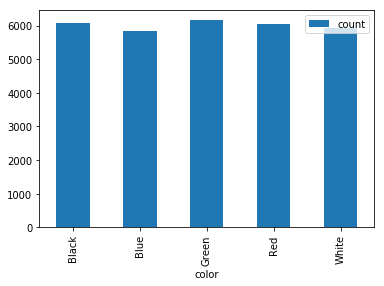

In [116]:
color_df = pd.DataFrame(color_result, columns=['color', 'count']);
color_df.plot.bar(x='color');

In [117]:
%%sql
DROP VIEW IF EXISTS color_count_2;
CREATE VIEW color_count_2 AS
SELECT data -> 'colors' AS colors, count(*) FROM cards GROUP BY colors;

SELECT * FROM color_count_2;

Done.
Done.
32 rows affected.


colors,count
None,7391
"['White', 'Red', 'Green']",54
"['Blue', 'Black', 'Green']",24
"['White', 'Black', 'Green']",28
"['White', 'Blue', 'Black', 'Red', 'Green']",37
"['White', 'Black', 'Red']",33
"['White', 'Blue', 'Red']",22
"['Blue', 'Red', 'Green']",25
['Red'],4858
"['White', 'Black']",174


In [134]:
color_result_2 = %sql SELECT * FROM color_count_2;

32 rows affected.


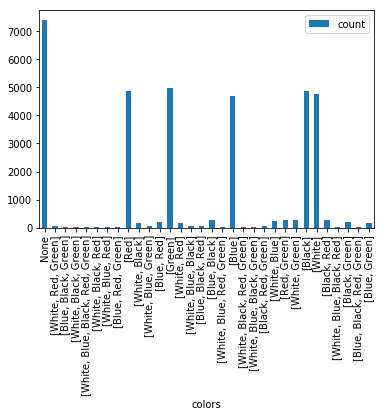

In [136]:
color_df_2 = pd.DataFrame(color_result_2, columns=['colors', 'count']);
color_df_3.plot.bar(x='colors');

Since it doesn't make much sense to make a histogram over the result, I've made a bar chart instead. I've made it for both the unique combination of colors, and over the individual colors. 
If you really want to see histograms, you can take a look below.

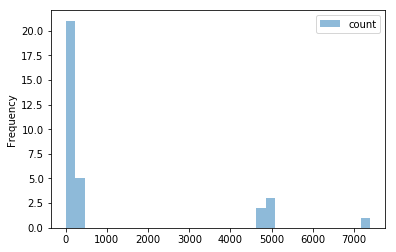

In [137]:
color_df_3 = pd.DataFrame(color_result_2, columns=['colors', 'count']);
color_df_3.plot.hist(stacked=True, bins=32, alpha=0.5);

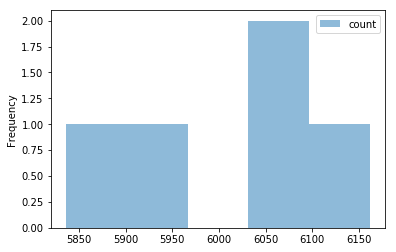

In [138]:
color_df.plot.hist(stacked=True, bins=5, alpha=0.5);